In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
voc_list = [2, 3, 4, 5, 7, 8, 9, 10]
base_tpl = "/home/gracejang42/CP/final_data/voc{}"
out_csv = "/home/gracejang42/CP/final_data/merged_voc2_3_4_5_7_8_9_10_long.csv"

In [3]:
rows = []
time_offset = 0  # 전체 누적 시간축

for voc in voc_list:
    base_root = base_tpl.format(voc)

    for folder_num in range(1, 11):
        folder_path = os.path.join(base_root, str(folder_num))
        if not os.path.exists(folder_path):
            continue

        subdirs = [d for d in os.listdir(folder_path)
                   if os.path.isdir(os.path.join(folder_path, d)) and d.startswith("con100_")]
        if not subdirs:
            continue

        con_dir = os.path.join(folder_path, sorted(subdirs)[0])

        folder_max_x = None

        for pos_idx in range(1, 10):
            csv_path = os.path.join(con_dir, f"pos{pos_idx}_time_sensor.csv")
            if not os.path.exists(csv_path):
                continue

            df = pd.read_csv(csv_path, index_col=0)

            # time index 숫자화
            t = pd.to_numeric(df.index, errors="coerce")
            df = df.loc[~t.isna()].copy()
            t = pd.to_numeric(df.index, errors="coerce").astype(int)

            folder_max_x = int(t.max()) if folder_max_x is None else max(folder_max_x, int(t.max()))

            # wide -> long
            long_df = df.copy()
            long_df["time"] = t.values
            long_df = long_df.melt(id_vars=["time"], var_name="sensor", value_name="value")

            long_df["voc"] = voc
            long_df["folder"] = folder_num
            long_df["pos"] = pos_idx
            long_df["merge_time"] = long_df["time"] + time_offset

            rows.append(long_df)

        if folder_max_x is not None:
            time_offset += folder_max_x + 1

merged = pd.concat(rows, ignore_index=True)
merged.to_csv(out_csv, index=False)
print("✅ Saved:", out_csv, "shape=", merged.shape)


✅ Saved: /home/gracejang42/CP/final_data/merged_voc2_3_4_5_7_8_9_10_long.csv shape= (576000, 7)


In [4]:
df = pd.read_csv("/home/gracejang42/CP/final_data/merged_voc2_3_4_5_7_8_9_10_long.csv")

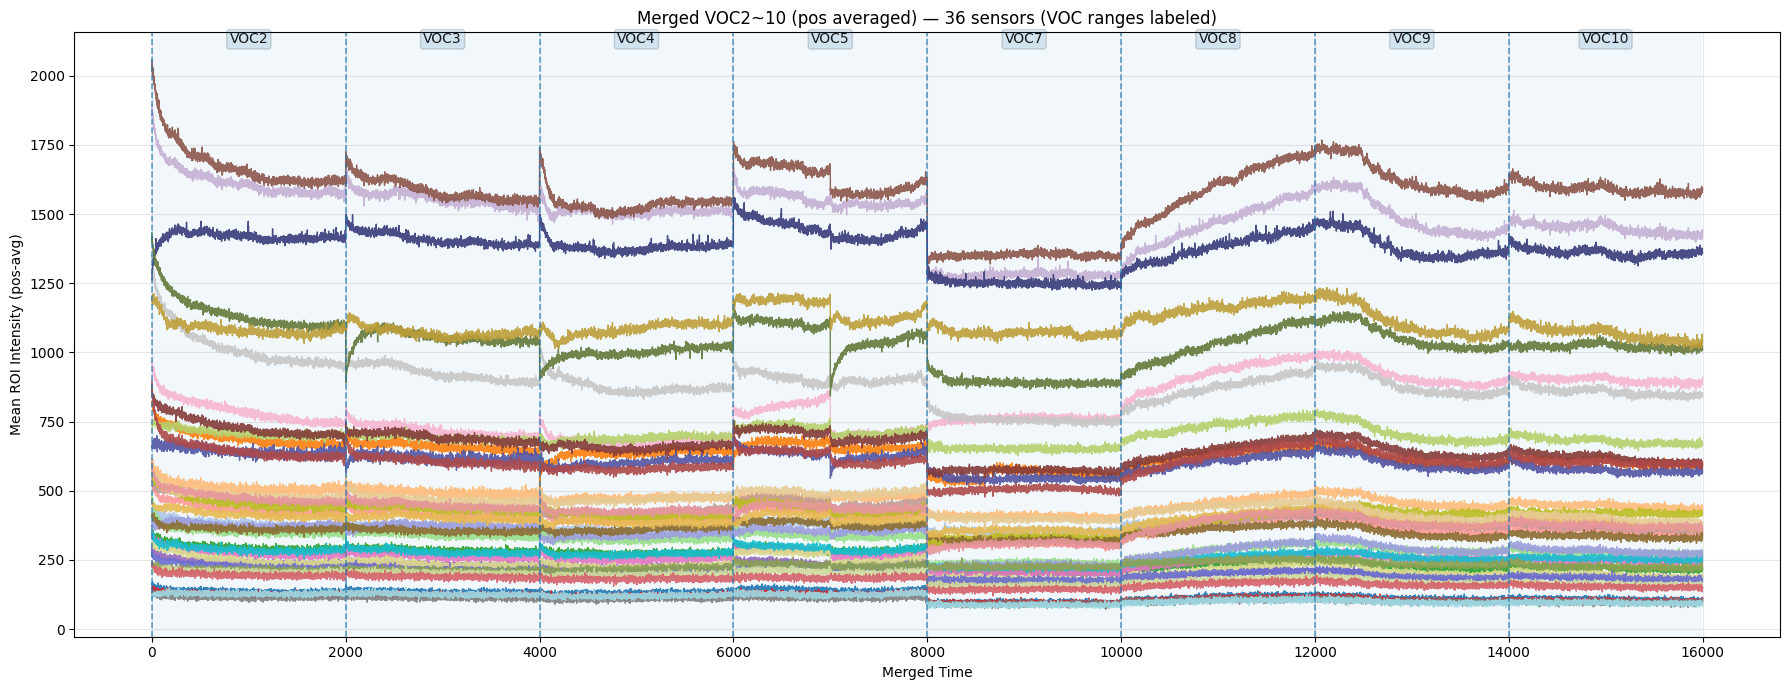

In [8]:
# 색 팔레트(60색)로 센서 색 고정
sensors = sorted(df["sensor"].unique())
c20  = list(plt.get_cmap("tab20").colors)
c20b = list(plt.get_cmap("tab20b").colors)
c20c = list(plt.get_cmap("tab20c").colors)
palette = c20 + c20b + c20c
sensor_color = {s: palette[i] for i, s in enumerate(sensors)}

fig, ax = plt.subplots(figsize=(18, 7))

# pos 평균 (라인 수 줄이기)
avg = df.groupby(["merge_time", "sensor"], as_index=False)["value"].mean()

for s in sensors:
    sub = avg[avg["sensor"] == s]
    ax.plot(sub["merge_time"], sub["value"], color=sensor_color[s], alpha=0.9, linewidth=1)
# =========================
# ✅ VOC 구간 계산 & 표시
# =========================
voc_ranges = (
    df.groupby("voc")["merge_time"]
      .agg(start="min", end="max")
      .sort_index()
      .reset_index()
)

y_top = ax.get_ylim()[1]

for _, r in voc_ranges.iterrows():
    voc = int(r["voc"])
    start = int(r["start"])
    end = int(r["end"])
    mid = (start + end) / 2

    # (1) 경계선
    ax.axvline(start, linestyle="--", linewidth=1.2, alpha=0.7)

    # (2) (옵션) 배경 음영: 보기 싫으면 이 줄만 주석 처리
    ax.axvspan(start, end, alpha=0.06)

    # (3) 라벨
    ax.text(
        mid, y_top, f"VOC{voc}",
        ha="center", va="top", fontsize=10, alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.2", alpha=0.15)
    )

ax.set_xlabel("Merged Time")
ax.set_ylabel("Mean ROI Intensity (pos-avg)")
ax.set_title("Merged VOC2~10 (pos averaged) — 36 sensors (VOC ranges labeled)")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# =========================
# 1) pos 평균으로 라인 수 줄이기
#    (merge_time, voc, sensor 기준으로 pos 평균)
# =========================
avg = df.groupby(["merge_time", "voc", "sensor"], as_index=False)["value"].mean()

In [11]:
# =========================
# 2) voc 내부(local) 시간축 만들기
#    voc마다 merge_time 시작점을 빼서 0~로 맞춤
# =========================
voc_start = avg.groupby("voc")["merge_time"].transform("min")
avg["voc_local_time"] = (avg["merge_time"] - voc_start).astype(int)

In [12]:
# =========================
# 3) 200개씩 10구간으로 나누기
# =========================
BLOCK_LEN = 200
BASE_LEN = 50

avg["block"] = (avg["voc_local_time"] // BLOCK_LEN).astype(int)        # 0~9
avg["t_in_block"] = (avg["voc_local_time"] % BLOCK_LEN).astype(int)    # 0~199


In [13]:
# =========================
# 4) baseline = 각 (voc, sensor, block)에서 t_in_block 0~49 평균
# =========================
baseline = (
    avg[avg["t_in_block"] < BASE_LEN]
    .groupby(["voc", "sensor", "block"], as_index=False)["value"]
    .mean()
    .rename(columns={"value": "baseline"})
)

avg = avg.merge(baseline, on=["voc", "sensor", "block"], how="left")

# baseline이 0이거나 NaN이면 나눗셈 문제 생기니 방어
avg = avg.dropna(subset=["baseline"])
avg = avg[avg["baseline"] != 0].copy()

In [14]:
# =========================
# 5) 정규화: (x - baseline) / baseline
# =========================
avg["norm"] = (avg["value"] - avg["baseline"]) / avg["baseline"]

# =========================
# 6) 센서별 색 고정(60색 팔레트)
# =========================
sensors = sorted(avg["sensor"].unique())
c20  = list(plt.get_cmap("tab20").colors)
c20b = list(plt.get_cmap("tab20b").colors)
c20c = list(plt.get_cmap("tab20c").colors)
palette = c20 + c20b + c20c
if len(sensors) > len(palette):
    raise RuntimeError(f"센서 {len(sensors)}개인데 palette는 {len(palette)}색뿐이야.")
sensor_color = {s: palette[i] for i, s in enumerate(sensors)}

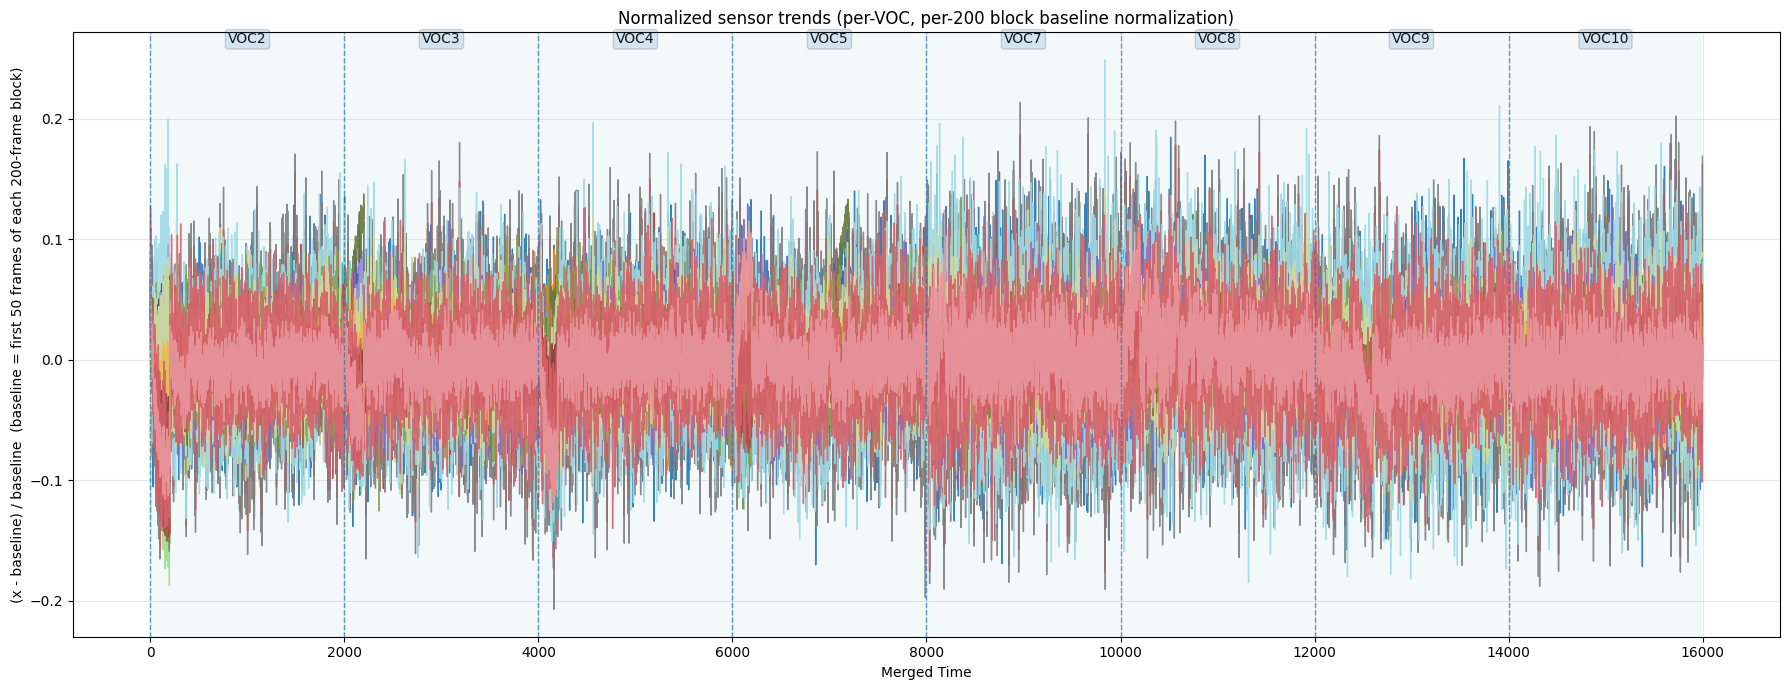

In [16]:
# =========================
# 7) Plot (전체 VOC 이어붙인 merge_time 기준)
# =========================
fig, ax = plt.subplots(figsize=(18, 7))

for s in sensors:
    sub = avg[avg["sensor"] == s].sort_values("merge_time")
    ax.plot(sub["merge_time"], sub["norm"], color=sensor_color[s], alpha=0.9, linewidth=1)

# VOC 구간 표시(경계 + 라벨)
voc_ranges = (
    avg.groupby("voc")["merge_time"]
      .agg(start="min", end="max")
      .sort_index()
      .reset_index()
)
y_top = ax.get_ylim()[1]
for _, r in voc_ranges.iterrows():
    voc = int(r["voc"])
    start = int(r["start"])
    end = int(r["end"])
    mid = (start + end) / 2

    ax.axvline(start, linestyle="--", linewidth=1.0, alpha=0.7)
    ax.axvspan(start, end, alpha=0.05)
    ax.text(mid, y_top, f"VOC{voc}", ha="center", va="top",
            fontsize=10, alpha=0.9,
            bbox=dict(boxstyle="round,pad=0.2", alpha=0.15))

ax.set_xlabel("Merged Time")
ax.set_ylabel("(x - baseline) / baseline  (baseline = first 50 frames of each 200-frame block)")
ax.set_title("Normalized sensor trends (per-VOC, per-200 block baseline normalization)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2128123/1049238268.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg = avg.groupby(["voc", "sensor"], group_keys=False).apply(smooth_group)


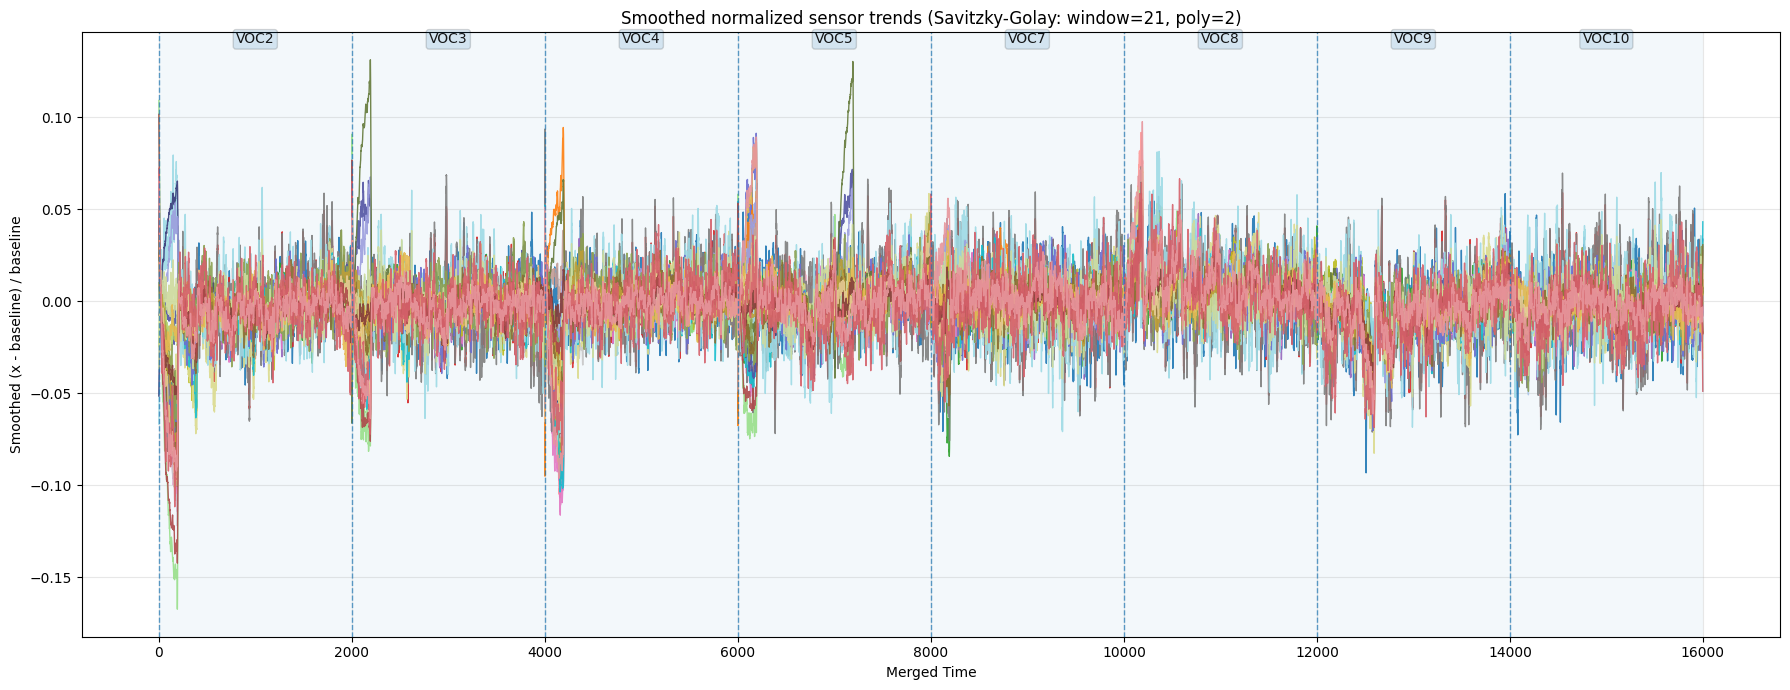

In [18]:
avg = df.groupby(["merge_time", "voc", "sensor"], as_index=False)["value"].mean()

voc_start = avg.groupby("voc")["merge_time"].transform("min")
avg["voc_local_time"] = (avg["merge_time"] - voc_start).astype(int)

BLOCK_LEN = 200
BASE_LEN = 50

avg["block"] = (avg["voc_local_time"] // BLOCK_LEN).astype(int)
avg["t_in_block"] = (avg["voc_local_time"] % BLOCK_LEN).astype(int)

baseline = (
    avg[avg["t_in_block"] < BASE_LEN]
    .groupby(["voc", "sensor", "block"], as_index=False)["value"]
    .mean()
    .rename(columns={"value": "baseline"})
)

avg = avg.merge(baseline, on=["voc", "sensor", "block"], how="left")
avg = avg.dropna(subset=["baseline"])
avg = avg[avg["baseline"] != 0].copy()

avg["norm"] = (avg["value"] - avg["baseline"]) / avg["baseline"]

# =========================
# ✅ 5.5) Smoothing (Savitzky–Golay)
#   - voc, sensor 단위로 각각 smoothing
#   - window_length는 홀수여야 함
# =========================
WINDOW = 21   # 11, 21, 31 등으로 조절 (클수록 더 부드러움)
POLY = 2

def smooth_group(g):
    g = g.sort_values("merge_time").copy()
    y = g["norm"].to_numpy()

    # 길이가 window보다 짧으면 smoothing 스킵
    if len(y) < WINDOW:
        g["norm_smooth"] = y
        return g

    # savgol은 window가 홀수여야 함
    w = WINDOW if WINDOW % 2 == 1 else WINDOW + 1
    if len(y) <= w:
        w = len(y) - 1 if (len(y) - 1) % 2 == 1 else len(y) - 2
    if w < 3:
        g["norm_smooth"] = y
        return g

    g["norm_smooth"] = savgol_filter(y, window_length=w, polyorder=min(POLY, w-1))
    return g

avg = avg.groupby(["voc", "sensor"], group_keys=False).apply(smooth_group)

# =========================
# 색 팔레트(60색)
# =========================
sensors = sorted(avg["sensor"].unique())
c20  = list(plt.get_cmap("tab20").colors)
c20b = list(plt.get_cmap("tab20b").colors)
c20c = list(plt.get_cmap("tab20c").colors)
palette = c20 + c20b + c20c
if len(sensors) > len(palette):
    raise RuntimeError(f"센서 {len(sensors)}개인데 palette는 {len(palette)}색뿐이야.")
sensor_color = {s: palette[i] for i, s in enumerate(sensors)}

# =========================
# Plot (smoothed)
# =========================
fig, ax = plt.subplots(figsize=(18, 7))

for s in sensors:
    sub = avg[avg["sensor"] == s].sort_values("merge_time")
    ax.plot(sub["merge_time"], sub["norm_smooth"], color=sensor_color[s], alpha=0.9, linewidth=1)

# VOC 구간 표시(경계 + 라벨)
voc_ranges = (
    avg.groupby("voc")["merge_time"]
      .agg(start="min", end="max")
      .sort_index()
      .reset_index()
)

y_top = ax.get_ylim()[1]
for _, r in voc_ranges.iterrows():
    voc = int(r["voc"])
    start = int(r["start"])
    end = int(r["end"])
    mid = (start + end) / 2

    ax.axvline(start, linestyle="--", linewidth=1.0, alpha=0.7)
    ax.axvspan(start, end, alpha=0.05)
    ax.text(mid, y_top, f"VOC{voc}", ha="center", va="top",
            fontsize=10, alpha=0.9,
            bbox=dict(boxstyle="round,pad=0.2", alpha=0.15))

ax.set_xlabel("Merged Time")
ax.set_ylabel("Smoothed (x - baseline) / baseline")
ax.set_title(f"Smoothed normalized sensor trends (Savitzky-Golay: window={WINDOW}, poly={POLY})")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
